# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [00:39<00:00, 2243.20it/s]


In [23]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [24]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

# Processing Texts from summary

In [25]:
preprocessed_reviews_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews_summary.append(sentance.strip())

 37%|███████████████████████████▌                                              | 32626/87773 [00:09<00:16, 3360.64it/s]C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 70%|███████████████████████████████████████████████████▌                      | 61151/87773 [00:18<00:07, 3353.85it/s]C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 75%|███████████████████████████████████████████████████████▏                  | 65519/87773 [00:19<00:06, 3350.67it/s]C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle

# Including Texts from summary in the main text

In [26]:
preprocessed_reviews_fe = []
for i in tqdm(range(0,len(preprocessed_reviews_summary))):
    preprocessed_reviews_fe.append(preprocessed_reviews_summary[i]+" "+ preprocessed_reviews[i])

100%|████████████████████████████████████████████████████████████████████████| 87773/87773 [00:00<00:00, 757548.59it/s]


# Adding length of text as a feature

In [27]:
preprocessed_reviews_fe_final = []
for i in tqdm(preprocessed_reviews_fe):
    count = 0;
    for j in i.split(" "):
        count += 1;
    i = i + " " + str(count);
    preprocessed_reviews_fe_final.append(i)

100%|████████████████████████████████████████████████████████████████████████| 87773/87773 [00:00<00:00, 119730.31it/s]


# Test - Train Split

In [108]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(preprocessed_reviews_fe_final, final['Score'], test_size=0.33) # this is random splitting
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33) # this is random splitting


## [4.1] BAG OF WORDS

In [109]:
count_vect = CountVectorizer( min_df = 10) #in scikit-learn

X_train_vect = count_vect.fit_transform(X_train)
X_train_vect = X_train_vect.toarray()
X_cv_vect = count_vect.transform(X_cv)
X_cv_vect = X_cv_vect.toarray()
X_test_vect = count_vect.transform(X_test)
X_test_vect = X_test_vect.toarray()

## [4.2] Bi-Grams and n-Grams.

## [4.3] TF-IDF

In [110]:
tf_idf = TfidfVectorizer(min_df = 10)
X_train_vect_tfidf = tf_idf.fit_transform(X_train)
X_train_vect_tfidf = X_train_vect_tfidf.toarray()
X_test_vect_tfidf = tf_idf.transform(X_test)
X_test_vect_tfidf = X_test_vect_tfidf.toarray()
X_cv_vect_tfidf = tf_idf.transform(X_cv)
X_cv_vect_tfidf = X_cv_vect_tfidf.toarray()

## [4.4] Word2Vec

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [31]:
# average Word2Vec
# compute average word2vec for each review.
i=0
list_of_sent=[]
X_train_list=[]
X_test_list=[]
X_cv_list=[]
for sent in X_train:
    X_train_list.append(sent.split())
    
for sent in X_cv:
    X_cv_list.append(sent.split())
    
for sent in X_test:
    X_test_list.append(sent.split())
    
w2v_model=Word2Vec(X_train_list,min_count=0,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

X_train_vectors = [];
for sent in tqdm(X_train_list): 
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_train_vectors.append(sent_vec)
    

X_cv_vectors = []
for sent in tqdm(X_cv_list): 
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_cv_vectors.append(sent_vec)
    
X_test_vectors = []
for sent in tqdm(X_test_list): 
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_test_vectors.append(sent_vec)

100%|███████████████████████████████████████████████████████████████████████████| 28966/28966 [01:43<00:00, 279.84it/s]


#### [4.4.1.2] TFIDF weighted W2v

In [32]:

dictionary = dict(zip(tf_idf.get_feature_names(), list(tf_idf.idf_)))
tfidf_feat = tf_idf.get_feature_names()
tfidf_X_train_vectors = [];
tfidf_X_test_vectors = [];
tfidf_X_cv_vectors = [];

for sent in tqdm(X_train_list):  
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in (w2v_words and tfidf_feat):
            vec = w2v_model.wv[word]
            tf_idf_count = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf_count)
            weight_sum += tf_idf_count
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_X_train_vectors.append(sent_vec)

for sent in tqdm(X_test_list):  
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in (w2v_words and tfidf_feat):
            vec = w2v_model.wv[word]
            tf_idf_count = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf_count)
            weight_sum += tf_idf_count
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_X_test_vectors.append(sent_vec)
    
for sent in tqdm(X_cv_list):  
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in (w2v_words and tfidf_feat):
            vec = w2v_model.wv[word]
            tf_idf_count = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf_count)
            weight_sum += tf_idf_count
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_X_cv_vectors.append(sent_vec)

100%|███████████████████████████████████████████████████████████████████████████| 19407/19407 [01:18<00:00, 247.00it/s]


# [5] Assignment 7: SVM

<ol>
    <li><strong>Apply SVM on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Procedure</strong>
        <ul>
    <li>You need to work with 2 versions of SVM
        <ul><li>Linear kernel</li>
            <li>RBF kernel</li></ul>
    <li>When you are working with linear kernel, use SGDClassifier’ with hinge loss because it is computationally less expensive.</li>
    <li>When you are working with ‘SGDClassifier’ with hinge loss and trying to find the AUC
        score, you would have to use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html'>CalibratedClassifierCV</a></li>
    <li>Similarly, like kdtree of knn, when you are working with RBF kernel it's better to reduce
the number of dimensions. You can put min_df = 10, max_features = 500 and consider a sample size of 40k points.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>When you are working on the linear kernel with BOW or TFIDF please print the top 10 best
features for each of the positive and negative classes.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying SVM

## [5.1] Linear SVM

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

# Gridsearch CV

In [33]:
# Please write all the code with proper documentation
from sklearn.linear_model import SGDClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV

lnr_svm = SGDClassifier()
tuned_parameters = [{'alpha': [10**-4,10**-3,10**-2, 10**-1, 10**0, 10**1,10**2,10**3,10**4]}]
alpha_list = [10**-4,10**-3,10**-2, 10**-1, 10**0, 10**1,10**2,10**3,10**4]
#Using GridSearchCV
model = GridSearchCV(SGDClassifier(loss = 'hinge'), tuned_parameters, scoring = 'roc_auc')
model.fit(X_train_vect, y_train)

print(model.best_estimator_)
print(model.score(X_test_vect, y_test))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


SGDClassifier(alpha=0.01, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
0.9490865012742677


# Simple CV

In [34]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
alpha_list = [10**-4,10**-3,10**-2, 10**-1, 10**0, 10**1,10**2,10**3,10**4]
ind = []
train_auc = []
cv_auc = []
for i in tqdm(alpha_list):
    lnr_svm = SGDClassifier(loss = 'hinge',alpha =i)
    cg_cv = CalibratedClassifierCV(base_estimator = lnr_svm)
    cg_cv.fit(X_train_vect, y_train)
    ind.append(i)
    y_train_pred =  cg_cv.predict_proba(X_train_vect)[:,1]
    y_cv_pred =  cg_cv.predict_proba(X_cv_vect)[:,1]
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [04:00<00:00, 27.35s/it]


# Plots


The optimal alpha is (according to auc curve (max auc)):  0.001


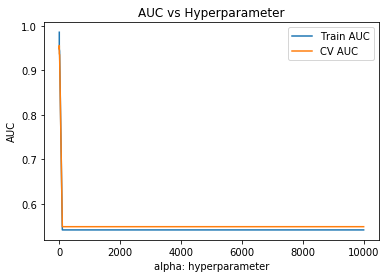

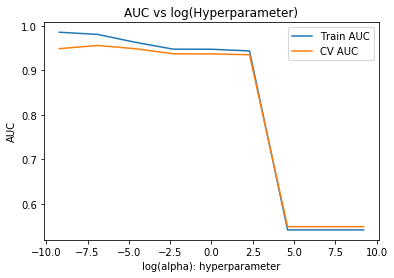

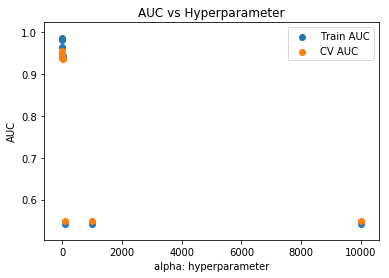

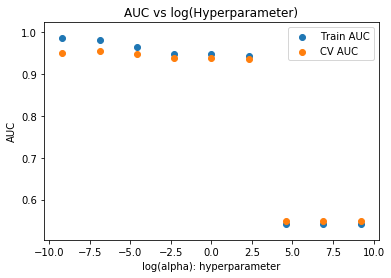

In [35]:
optimal_alpha_auc = ind[cv_auc.index(max(cv_auc))]
print('\nThe optimal alpha is (according to auc curve (max auc)): ' , optimal_alpha_auc)

plt.plot(alpha_list, train_auc, label='Train AUC')
plt.plot(alpha_list, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs Hyperparameter")
plt.show()

plt.plot(np.log(alpha_list), train_auc, label='Train AUC')
plt.plot(np.log(alpha_list), cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("log(alpha): hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs log(Hyperparameter)")
plt.show()


plt.scatter(alpha_list, train_auc, label='Train AUC')
plt.scatter(alpha_list, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs Hyperparameter")
plt.show()

plt.scatter(np.log(alpha_list), train_auc, label='Train AUC')
plt.scatter(np.log(alpha_list), cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("log(alpha): hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs log(Hyperparameter)")
plt.show()



****Test accuracy for alpha = 0.001000 is 93.267969%


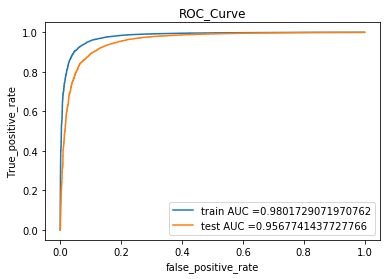

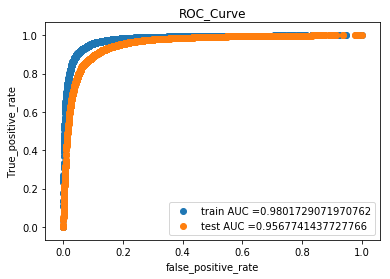

In [36]:
lnr_svm = SGDClassifier(loss = 'hinge',alpha =optimal_alpha_auc)
cg_cv = CalibratedClassifierCV(base_estimator = lnr_svm)
cg_cv.fit(X_train_vect, y_train)
pred = cg_cv.predict(X_test_vect)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for alpha = %f is %f%%' % (optimal_alpha_auc,acc))

train_fpr, train_tpr, thresholds = roc_curve(y_train, cg_cv.predict_proba(X_train_vect)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, cg_cv.predict_proba(X_test_vect)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("false_positive_rate")
plt.ylabel("True_positive_rate")
plt.title("ROC_Curve")
plt.show()



plt.scatter(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.scatter(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("false_positive_rate")
plt.ylabel("True_positive_rate")
plt.title("ROC_Curve")
plt.show()

print("="*100)



# Confusion Matrix (Train)

In [37]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix\n")
print(confusion_matrix(y_train, cg_cv.predict(X_train_vect)))

Train confusion matrix

[[ 4890  1519]
 [  384 32607]]


# Heat Map (Train)

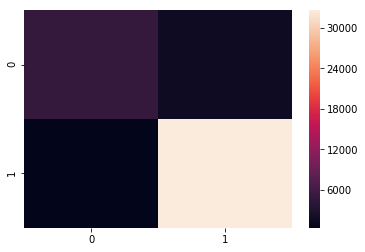

In [38]:
sns.heatmap(confusion_matrix(y_train, cg_cv.predict(X_train_vect)))

# Confusion Matrix (Test)

In [39]:
print("Test confusion matrix\n")
print(confusion_matrix(y_test, cg_cv.predict(X_test_vect)))

Test confusion matrix

[[ 3192  1455]
 [  495 23824]]


# Heat Map (Test)

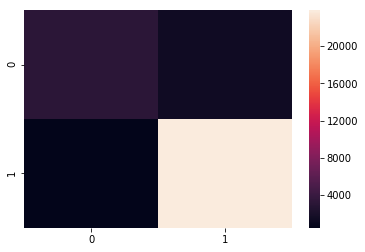

In [40]:
sns.heatmap(confusion_matrix(y_test, cg_cv.predict(X_test_vect)))

# Top 10 important features of positive class

In [114]:
# Please write all the code with proper documentation
lnr_svm = SGDClassifier(loss = 'hinge',alpha =0.001)
lnr_svm.fit(X_train_vect, y_train)
vocab = list(count_vect.get_feature_names())
weights = list(lnr_svm.coef_[0])
dict_new = {'Words':vocab,'weights':weights}
df_new = pd.DataFrame(dict_new)
df_pos_sorted =df_new.sort_values('weights', axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last')
df_neg_sorted =df_new.sort_values('weights', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
print("The important features for predicting the positive class are the following:")
print(df_pos_sorted[0:10])
print("\n")

The important features for predicting the positive class are the following:
          Words   weights
1962  delicious  0.821598
2545  excellent  0.791168
361     amazing  0.730309
8084      yummy  0.664378
3206      great  0.618734
5173    perfect  0.613662
732        best  0.603519
575     awesome  0.593376
4757       nice  0.562946
7978  wonderful  0.562946




# Top 10 important features of negative class 

In [115]:
print("The important features for predicting the negative class are the following:")
print(df_neg_sorted[0:10])

The important features for predicting the negative class are the following:
               Words   weights
8011           worst -0.943316
2124   disappointing -0.923029
576            awful -0.826669
2123    disappointed -0.806383
7244        terrible -0.801311
2125  disappointment -0.770882
8073            yuck -0.745524
3472        horrible -0.735381
5346            poor -0.699879
6019             rip -0.623806


### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

# GridSearchCV

In [41]:
# Please write all the code with proper documentation
from sklearn.linear_model import SGDClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV

lnr_svm = SGDClassifier()
tuned_parameters = [{'alpha': [10**-4,10**-3,10**-2, 10**-1, 10**0, 10**1,10**2,10**3,10**4]}]
alpha_list = [10**-4,10**-3,10**-2, 10**-1, 10**0, 10**1,10**2,10**3,10**4]
#Using GridSearchCV
model = GridSearchCV(SGDClassifier(loss = 'hinge'), tuned_parameters, scoring = 'roc_auc')
model.fit(X_train_vect_tfidf, y_train)

print(model.best_estimator_)
print(model.score(X_test_vect_tfidf, y_test))

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
0.9659765540325128


# SimpleCV

In [42]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
alpha_list = [10**-4,10**-3,10**-2, 10**-1, 10**0, 10**1,10**2,10**3,10**4]
ind = []
train_auc = []
cv_auc = []
for i in tqdm(alpha_list):
    lnr_svm = SGDClassifier(loss = 'hinge',alpha =i)
    cg_cv = CalibratedClassifierCV(base_estimator = lnr_svm)
    cg_cv.fit(X_train_vect_tfidf, y_train)
    ind.append(i)
    y_train_pred =  cg_cv.predict_proba(X_train_vect_tfidf)[:,1]
    y_cv_pred =  cg_cv.predict_proba(X_cv_vect_tfidf)[:,1]
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [02:26<00:00, 16.99s/it]


# Plots


The optimal alpha is (according to auc curve (max auc)):  0.0001


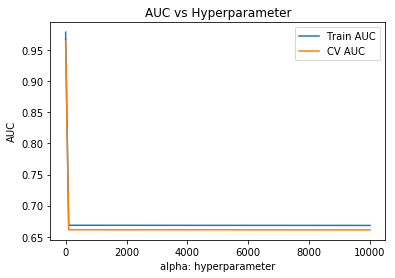

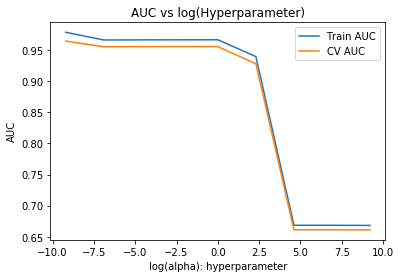

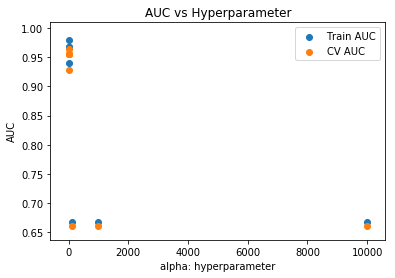

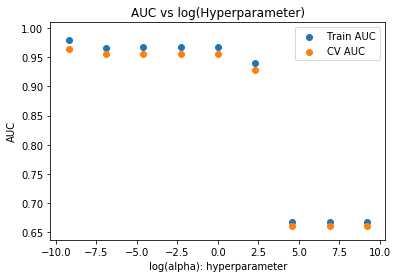

In [43]:
optimal_alpha_auc = ind[cv_auc.index(max(cv_auc))]
print('\nThe optimal alpha is (according to auc curve (max auc)): ' , optimal_alpha_auc)

plt.plot(alpha_list, train_auc, label='Train AUC')
plt.plot(alpha_list, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs Hyperparameter")
plt.show()

plt.plot(np.log(alpha_list), train_auc, label='Train AUC')
plt.plot(np.log(alpha_list), cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("log(alpha): hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs log(Hyperparameter)")
plt.show()


plt.scatter(alpha_list, train_auc, label='Train AUC')
plt.scatter(alpha_list, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs Hyperparameter")
plt.show()

plt.scatter(np.log(alpha_list), train_auc, label='Train AUC')
plt.scatter(np.log(alpha_list), cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("log(alpha): hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs log(Hyperparameter)")
plt.show()



****Test accuracy for alpha = 0.000100 is 93.602845%


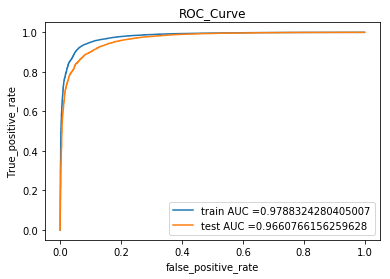

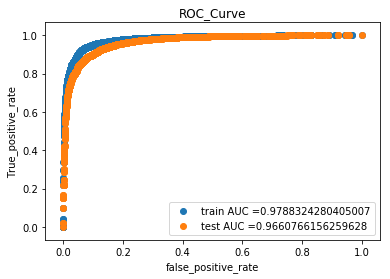

In [44]:
lnr_svm = SGDClassifier(loss = 'hinge',alpha =optimal_alpha_auc)
cg_cv = CalibratedClassifierCV(base_estimator = lnr_svm)
cg_cv.fit(X_train_vect_tfidf, y_train)
pred = cg_cv.predict(X_test_vect_tfidf)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for alpha = %f is %f%%' % (optimal_alpha_auc,acc))

train_fpr, train_tpr, thresholds = roc_curve(y_train, cg_cv.predict_proba(X_train_vect_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, cg_cv.predict_proba(X_test_vect_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("false_positive_rate")
plt.ylabel("True_positive_rate")
plt.title("ROC_Curve")
plt.show()



plt.scatter(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.scatter(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("false_positive_rate")
plt.ylabel("True_positive_rate")
plt.title("ROC_Curve")
plt.show()

print("="*100)



# Confusion Matrix (Train)

In [45]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix\n")
print(confusion_matrix(y_train, cg_cv.predict(X_train_vect_tfidf)))

Train confusion matrix

[[ 4989  1420]
 [  598 32393]]


# Heat Map (Train)

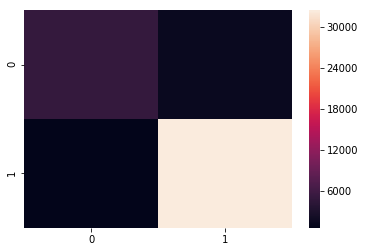

In [46]:
sns.heatmap(confusion_matrix(y_train, cg_cv.predict(X_train_vect_tfidf)))

# Confusion Matrix (Train)

In [47]:
print("Test confusion matrix\n")
print(confusion_matrix(y_test, cg_cv.predict(X_test_vect_tfidf)))

Test confusion matrix

[[ 3397  1250]
 [  603 23716]]


# Heat Map (Train)

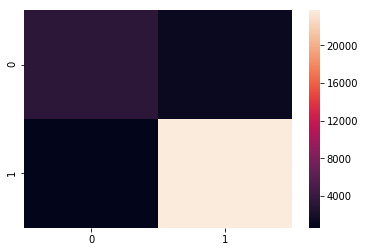

In [48]:
sns.heatmap(confusion_matrix(y_test, cg_cv.predict(X_test_vect_tfidf)))

# Top 10 important features of positive class 

In [116]:
# Please write all the code with proper documentation
lnr_svm = SGDClassifier(loss = 'hinge',alpha =0.0001)
lnr_svm.fit(X_train_vect_tfidf, y_train)
vocab = list(tf_idf.get_feature_names())
weights = list(lnr_svm.coef_[0])
dict_new = {'Words':vocab,'weights':weights}
df_new = pd.DataFrame(dict_new)
df_pos_sorted =df_new.sort_values('weights', axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last')
df_neg_sorted =df_new.sort_values('weights', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
print("The important features for predicting the positive class are the following:")
print(df_pos_sorted[0:10])
print("\n")

The important features for predicting the positive class are the following:
          Words   weights
3206      great  5.479673
732        best  3.935325
3143       good  3.877516
1962  delicious  3.691458
2545  excellent  3.088592
4757       nice  2.902722
4222       love  2.900174
5173    perfect  2.738491
4227      loves  2.630345
361     amazing  2.387689




# Top 10 important features of negative class 

In [117]:
print("The important features for predicting the negative class are the following:")
print(df_neg_sorted[0:10])

The important features for predicting the negative class are the following:
               Words   weights
4794             not -4.356391
2123    disappointed -3.866092
8011           worst -3.503328
7244        terrible -3.400240
576            awful -3.297672
2124   disappointing -3.281162
3472        horrible -3.216841
5346            poor -2.697623
8073            yuck -2.661658
2125  disappointment -2.638946


### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

# GridSearch CV

In [49]:

from sklearn.linear_model import SGDClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV

lnr_svm = SGDClassifier()
tuned_parameters = [{'alpha': [10**-4,10**-3,10**-2, 10**-1, 10**0, 10**1,10**2,10**3,10**4]}]
alpha_list = [10**-4,10**-3,10**-2, 10**-1, 10**0, 10**1,10**2,10**3,10**4]
#Using GridSearchCV
model = GridSearchCV(SGDClassifier(loss = 'hinge'), tuned_parameters, scoring = 'roc_auc')
model.fit(X_train_vectors, y_train)

print(model.best_estimator_)
print(model.score(X_test_vectors, y_test))

SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
0.9185655429054211


# SimpleCV

In [50]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
alpha_list = [10**-4,10**-3,10**-2, 10**-1, 10**0, 10**1,10**2,10**3,10**4]
ind = []
train_auc = []
cv_auc = []
for i in tqdm(alpha_list):
    lnr_svm = SGDClassifier(loss = 'hinge',alpha =i)
    cg_cv = CalibratedClassifierCV(base_estimator = lnr_svm)
    cg_cv.fit(X_train_vectors, y_train)
    ind.append(i)
    y_train_pred =  cg_cv.predict_proba(X_train_vectors)[:,1]
    y_cv_pred =  cg_cv.predict_proba(X_cv_vectors)[:,1]
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.52it/s]


# Plots


The optimal alpha is (according to auc curve (max auc)):  0.001


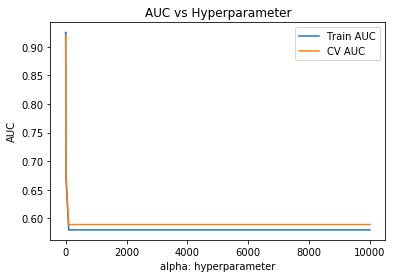

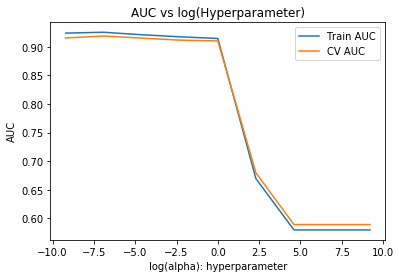

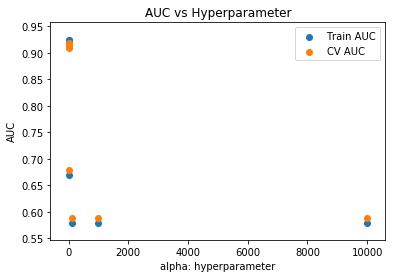

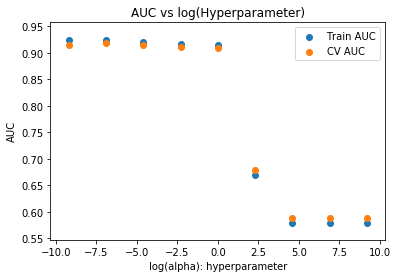

In [51]:
optimal_alpha_auc = ind[cv_auc.index(max(cv_auc))]
print('\nThe optimal alpha is (according to auc curve (max auc)): ' , optimal_alpha_auc)

plt.plot(alpha_list, train_auc, label='Train AUC')
plt.plot(alpha_list, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs Hyperparameter")
plt.show()

plt.plot(np.log(alpha_list), train_auc, label='Train AUC')
plt.plot(np.log(alpha_list), cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("log(alpha): hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs log(Hyperparameter)")
plt.show()


plt.scatter(alpha_list, train_auc, label='Train AUC')
plt.scatter(alpha_list, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs Hyperparameter")
plt.show()

plt.scatter(np.log(alpha_list), train_auc, label='Train AUC')
plt.scatter(np.log(alpha_list), cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("log(alpha): hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs log(Hyperparameter)")
plt.show()



****Test accuracy for alpha = 0.001000 is 89.798384%


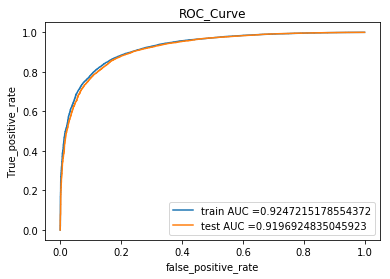

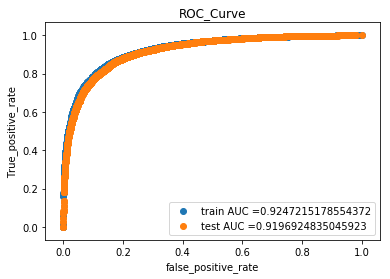

In [52]:
lnr_svm = SGDClassifier(loss = 'hinge',alpha =optimal_alpha_auc)
cg_cv = CalibratedClassifierCV(base_estimator = lnr_svm)
cg_cv.fit(X_train_vectors, y_train)
pred = cg_cv.predict(X_test_vectors)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for alpha = %f is %f%%' % (optimal_alpha_auc,acc))

train_fpr, train_tpr, thresholds = roc_curve(y_train, cg_cv.predict_proba(X_train_vectors)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, cg_cv.predict_proba(X_test_vectors)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("false_positive_rate")
plt.ylabel("True_positive_rate")
plt.title("ROC_Curve")
plt.show()



plt.scatter(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.scatter(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("false_positive_rate")
plt.ylabel("True_positive_rate")
plt.title("ROC_Curve")
plt.show()

print("="*100)


# Confusion Matrix( Test)

In [53]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix\n")
print(confusion_matrix(y_train, cg_cv.predict(X_train_vectors)))

Train confusion matrix

[[ 3536  2873]
 [ 1148 31843]]


# Heat Map ( Test)

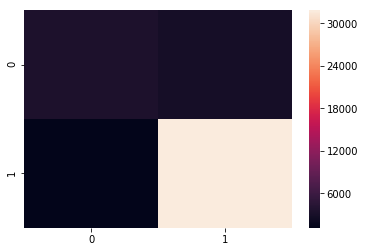

In [54]:
sns.heatmap(confusion_matrix(y_train, cg_cv.predict(X_train_vectors)))

# Confusion matrix (Test)

In [55]:
print("Test confusion matrix\n")
print(confusion_matrix(y_test, cg_cv.predict(X_test_vectors)))

Test confusion matrix

[[ 2540  2107]
 [  848 23471]]


# Heat Map (Test)

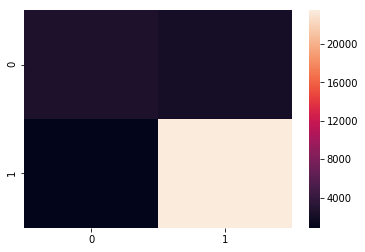

In [56]:
sns.heatmap(confusion_matrix(y_test, cg_cv.predict(X_test_vectors)))

### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

# GridSearch CV

In [57]:
# Please write all the code with proper documentation

from sklearn.linear_model import SGDClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV

lnr_svm = SGDClassifier()
tuned_parameters = [{'alpha': [10**-4,10**-3,10**-2, 10**-1, 10**0, 10**1,10**2,10**3,10**4]}]
alpha_list = [10**-4,10**-3,10**-2, 10**-1, 10**0, 10**1,10**2,10**3,10**4]
#Using GridSearchCV
model = GridSearchCV(SGDClassifier(loss = 'hinge'), tuned_parameters, scoring = 'roc_auc')
model.fit(tfidf_X_train_vectors, y_train)

print(model.best_estimator_)
print(model.score(tfidf_X_test_vectors, y_test))

SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
0.8941577435271817


# SimpleCV

In [58]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
alpha_list = [10**-4,10**-3,10**-2, 10**-1, 10**0, 10**1,10**2,10**3,10**4]
ind = []
train_auc = []
cv_auc = []
for i in tqdm(alpha_list):
    lnr_svm = SGDClassifier(loss = 'hinge',alpha =i)
    cg_cv = CalibratedClassifierCV(base_estimator = lnr_svm)
    cg_cv.fit(tfidf_X_train_vectors, y_train)
    ind.append(i)
    y_train_pred =  cg_cv.predict_proba(tfidf_X_train_vectors)[:,1]
    y_cv_pred =  cg_cv.predict_proba(tfidf_X_cv_vectors)[:,1]
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.63it/s]



The optimal alpha is (according to auc curve (max auc)):  0.001


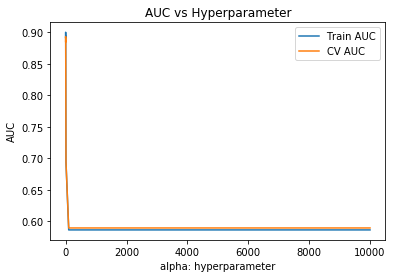

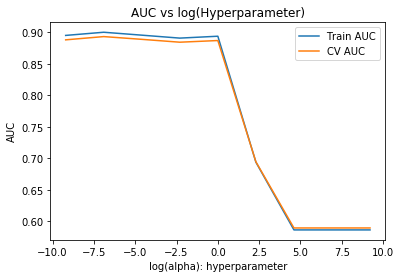

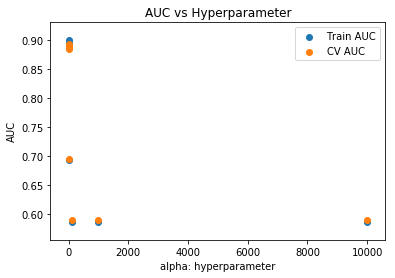

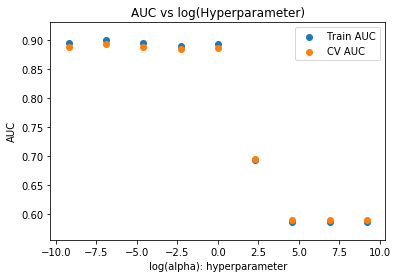

In [59]:
optimal_alpha_auc = ind[cv_auc.index(max(cv_auc))]
print('\nThe optimal alpha is (according to auc curve (max auc)): ' , optimal_alpha_auc)

plt.plot(alpha_list, train_auc, label='Train AUC')
plt.plot(alpha_list, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs Hyperparameter")
plt.show()

plt.plot(np.log(alpha_list), train_auc, label='Train AUC')
plt.plot(np.log(alpha_list), cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("log(alpha): hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs log(Hyperparameter)")
plt.show()


plt.scatter(alpha_list, train_auc, label='Train AUC')
plt.scatter(alpha_list, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs Hyperparameter")
plt.show()

plt.scatter(np.log(alpha_list), train_auc, label='Train AUC')
plt.scatter(np.log(alpha_list), cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("log(alpha): hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs log(Hyperparameter)")
plt.show()



****Test accuracy for alpha = 0.001000 is 88.534834%


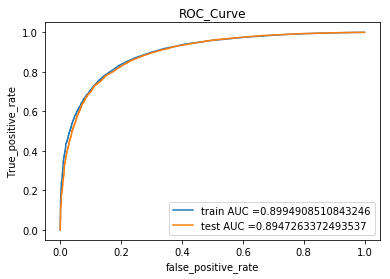

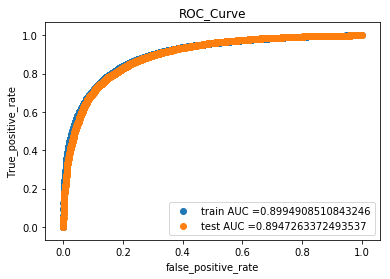

In [60]:
lnr_svm = SGDClassifier(loss = 'hinge',alpha =optimal_alpha_auc)
cg_cv = CalibratedClassifierCV(base_estimator = lnr_svm)
cg_cv.fit(tfidf_X_train_vectors, y_train)
pred = cg_cv.predict(tfidf_X_test_vectors)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for alpha = %f is %f%%' % (optimal_alpha_auc,acc))

train_fpr, train_tpr, thresholds = roc_curve(y_train, cg_cv.predict_proba(tfidf_X_train_vectors)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, cg_cv.predict_proba(tfidf_X_test_vectors)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("false_positive_rate")
plt.ylabel("True_positive_rate")
plt.title("ROC_Curve")
plt.show()



plt.scatter(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.scatter(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("false_positive_rate")
plt.ylabel("True_positive_rate")
plt.title("ROC_Curve")
plt.show()

print("="*100)


# Confusion Matrix (Train)

In [61]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix\n")
print(confusion_matrix(y_train, cg_cv.predict(tfidf_X_train_vectors)))

Train confusion matrix

[[ 2881  3528]
 [ 1094 31897]]


# Heat Map (Train)

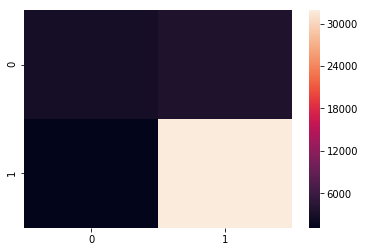

In [62]:
sns.heatmap(confusion_matrix(y_train, cg_cv.predict(tfidf_X_train_vectors)))

# Confusion Matrix (Test)

In [63]:
print("Test confusion matrix\n")
print(confusion_matrix(y_test, cg_cv.predict(tfidf_X_test_vectors)))

Test confusion matrix

[[ 2095  2552]
 [  769 23550]]


# Heat Map (Test)

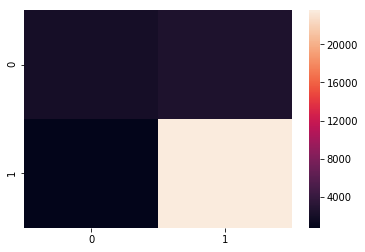

In [64]:
sns.heatmap(confusion_matrix(y_test, cg_cv.predict(tfidf_X_test_vectors)))

## [5.2] RBF SVM

# Test Train Split

* Considering 20k features for the RBF_SVM

In [65]:
X_train, X_test, y_train, y_test = train_test_split(preprocessed_reviews_fe_final[0:20000], final['Score'][0:20000], test_size=0.33) # this is random splitting
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33) # this is random splitting

# BOW for RBF SVC

In [66]:
count_vect = CountVectorizer(min_df=10, max_features=500) #in scikit-learn

X_train_vect = count_vect.fit_transform(X_train)
X_train_vect = X_train_vect.toarray()
X_cv_vect = count_vect.transform(X_cv)
X_cv_vect = X_cv_vect.toarray()
X_test_vect = count_vect.transform(X_test)
X_test_vect = X_test_vect.toarray()

# TFIDF for RBF SVC

In [67]:
tf_idf = TfidfVectorizer(min_df=10, max_features=500)
X_train_vect_tfidf = tf_idf.fit_transform(X_train)
X_train_vect_tfidf = X_train_vect_tfidf.toarray()
X_test_vect_tfidf = tf_idf.transform(X_test)
X_test_vect_tfidf = X_test_vect_tfidf.toarray()
X_cv_vect_tfidf = tf_idf.transform(X_cv)
X_cv_vect_tfidf = X_cv_vect_tfidf.toarray()

# Avg Word2Vec for RBF SVC

In [68]:
i=0
list_of_sent=[]
X_train_list=[]
X_test_list=[]
X_cv_list=[]
for sent in X_train:
    X_train_list.append(sent.split())
    
for sent in X_cv:
    X_cv_list.append(sent.split())
    
for sent in X_test:
    X_test_list.append(sent.split())
    
w2v_model=Word2Vec(X_train_list,min_count=0,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

X_train_vectors = [];
for sent in tqdm(X_train_list): 
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_train_vectors.append(sent_vec)
    

X_cv_vectors = []
for sent in tqdm(X_cv_list): 
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_cv_vectors.append(sent_vec)
    
X_test_vectors = []
for sent in tqdm(X_test_list): 
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_test_vectors.append(sent_vec)

100%|█████████████████████████████████████████████████████████████████████████████| 6600/6600 [00:18<00:00, 353.19it/s]


# Tfidf-Avg Word2Vec for RBF SVC

In [69]:
dictionary = dict(zip(tf_idf.get_feature_names(), list(tf_idf.idf_)))
tfidf_feat = tf_idf.get_feature_names()
tfidf_X_train_vectors = [];
tfidf_X_test_vectors = [];
tfidf_X_cv_vectors = [];

for sent in tqdm(X_train_list):  
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in (w2v_words and tfidf_feat):
            vec = w2v_model.wv[word]
            tf_idf_count = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf_count)
            weight_sum += tf_idf_count
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_X_train_vectors.append(sent_vec)

for sent in tqdm(X_test_list):  
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in (w2v_words and tfidf_feat):
            vec = w2v_model.wv[word]
            tf_idf_count = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf_count)
            weight_sum += tf_idf_count
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_X_test_vectors.append(sent_vec)
    
for sent in tqdm(X_cv_list):  
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in (w2v_words and tfidf_feat):
            vec = w2v_model.wv[word]
            tf_idf_count = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf_count)
            weight_sum += tf_idf_count
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_X_cv_vectors.append(sent_vec)

100%|████████████████████████████████████████████████████████████████████████████| 4422/4422 [00:02<00:00, 1633.53it/s]


### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

# GridSearchCV

In [70]:
# Please write all the code with proper documentation
from sklearn.svm import SVC
tuned_parameters = [{'C': [10**-4,10**-3,10**-2, 10**-1, 10**0, 10**1,10**2,10**3,10**4]}]
alpha_list = [10**-4,10**-3,10**-2, 10**-1, 10**0, 10**1,10**2,10**3,10**4]
#Using GridSearchCV
model = GridSearchCV(SVC(), tuned_parameters, scoring = 'roc_auc')
model.fit(X_train_vect, y_train)

print(model.best_estimator_)
print(model.score(X_test_vect, y_test))

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
0.9230691854896195


# SimpleCV

In [71]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
alpha_list = [10**-4,10**-3,10**-2, 10**-1, 10**0, 10**1,10**2,10**3,10**4]
ind = []
train_auc = []
cv_auc = []
for i in tqdm(alpha_list):
    rbf_svm = SVC(C = i)
    cg_cv = CalibratedClassifierCV(base_estimator = rbf_svm)
    cg_cv.fit(X_train_vect, y_train)
    ind.append(i)
    y_train_pred =  cg_cv.predict_proba(X_train_vect)[:,1]
    y_cv_pred =  cg_cv.predict_proba(X_cv_vect)[:,1]
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [10:59<00:00, 71.33s/it]


# Plots


The optimal alpha is (according to auc curve (max auc)):  100


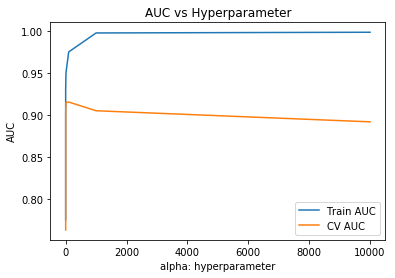

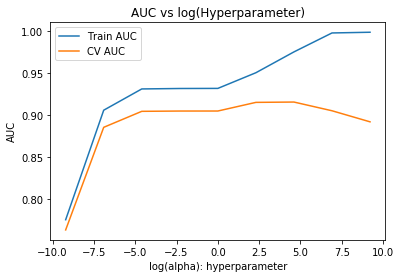

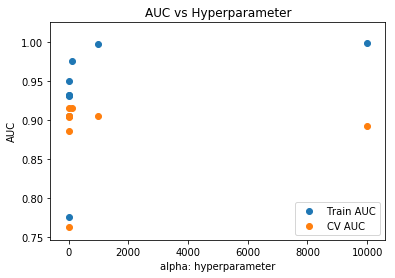

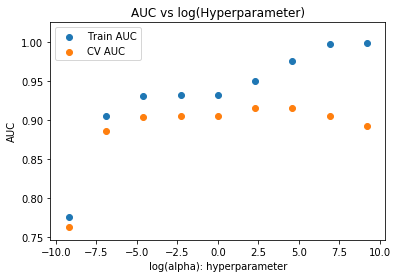

In [72]:
optimal_alpha_auc = ind[cv_auc.index(max(cv_auc))]
print('\nThe optimal alpha is (according to auc curve (max auc)): ' , optimal_alpha_auc)

plt.plot(alpha_list, train_auc, label='Train AUC')
plt.plot(alpha_list, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs Hyperparameter")
plt.show()

plt.plot(np.log(alpha_list), train_auc, label='Train AUC')
plt.plot(np.log(alpha_list), cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("log(alpha): hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs log(Hyperparameter)")
plt.show()


plt.scatter(alpha_list, train_auc, label='Train AUC')
plt.scatter(alpha_list, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs Hyperparameter")
plt.show()

plt.scatter(np.log(alpha_list), train_auc, label='Train AUC')
plt.scatter(np.log(alpha_list), cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("log(alpha): hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs log(Hyperparameter)")
plt.show()



****Test accuracy for alpha = 100.000000 is 89.803030%


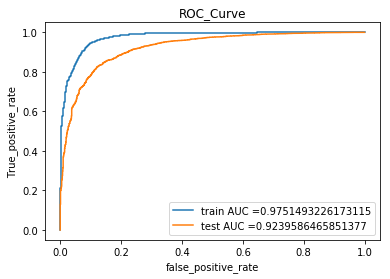

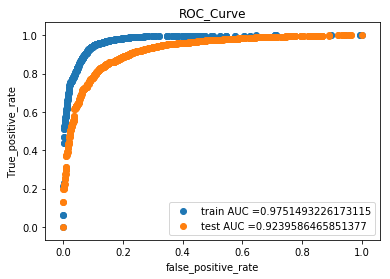

In [73]:
rbf_svm = SVC(C =optimal_alpha_auc)
cg_cv = CalibratedClassifierCV(base_estimator = rbf_svm)
cg_cv.fit(X_train_vect, y_train)
pred = cg_cv.predict(X_test_vect)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for alpha = %f is %f%%' % (optimal_alpha_auc,acc))

train_fpr, train_tpr, thresholds = roc_curve(y_train, cg_cv.predict_proba(X_train_vect)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, cg_cv.predict_proba(X_test_vect)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("false_positive_rate")
plt.ylabel("True_positive_rate")
plt.title("ROC_Curve")
plt.show()



plt.scatter(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.scatter(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("false_positive_rate")
plt.ylabel("True_positive_rate")
plt.title("ROC_Curve")
plt.show()

print("="*100)




# Confusion Matrix (Train)

In [74]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix\n")
print(confusion_matrix(y_train, cg_cv.predict(X_train_vect)))

Train confusion matrix

[[ 881  462]
 [  36 7599]]


# Heat Map (Train)

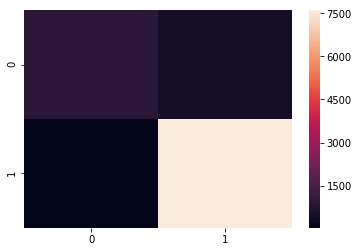

In [75]:
sns.heatmap(confusion_matrix(y_train, cg_cv.predict(X_train_vect)))

# Confusion Matrix (Test)

In [76]:
print("Test confusion matrix\n")
print(confusion_matrix(y_test, cg_cv.predict(X_test_vect)))

Test confusion matrix

[[ 484  548]
 [ 125 5443]]


# Heat Map (Test)

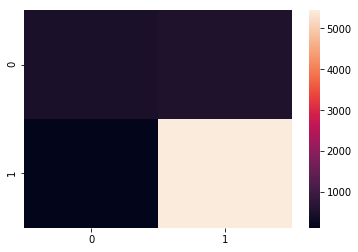

In [77]:
sns.heatmap(confusion_matrix(y_test, cg_cv.predict(X_test_vect)))

### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

# GridSearchCV

In [78]:

from sklearn.linear_model import SGDClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV

tuned_parameters = [{'C': [10**-4,10**-3,10**-2, 10**-1, 10**0, 10**1,10**2,10**3,10**4]}]
alpha_list = [10**-4,10**-3,10**-2, 10**-1, 10**0, 10**1,10**2,10**3,10**4]
#Using GridSearchCV
model = GridSearchCV(SVC(), tuned_parameters, scoring = 'roc_auc')
model.fit(X_train_vect_tfidf, y_train)

print(model.best_estimator_)
print(model.score(X_test_vect_tfidf, y_test))

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
0.9267042986500935


# SimpleCV

In [79]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
alpha_list = [10**-4,10**-3,10**-2, 10**-1, 10**0, 10**1,10**2,10**3,10**4]
ind = []
train_auc = []
cv_auc = []
for i in tqdm(alpha_list):
    rbf_svm = SVC(C = i)
    cg_cv = CalibratedClassifierCV(base_estimator = rbf_svm)
    cg_cv.fit(X_train_vect_tfidf, y_train)
    ind.append(i)
    y_train_pred =  cg_cv.predict_proba(X_train_vect_tfidf)[:,1]
    y_cv_pred =  cg_cv.predict_proba(X_cv_vect_tfidf)[:,1]
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [10:30<00:00, 68.43s/it]


# Plots


The optimal alpha is (according to auc curve (max auc)):  1000


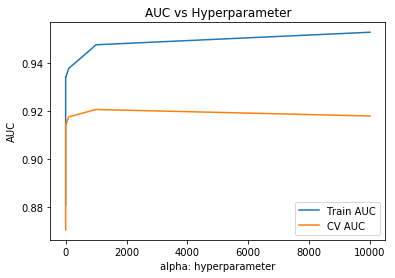

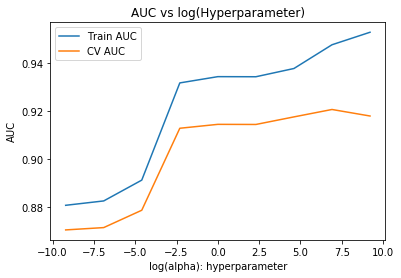

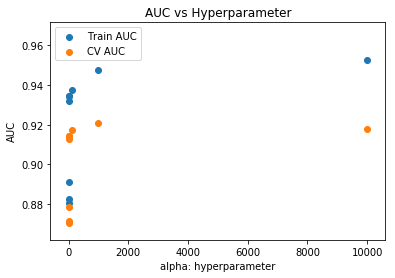

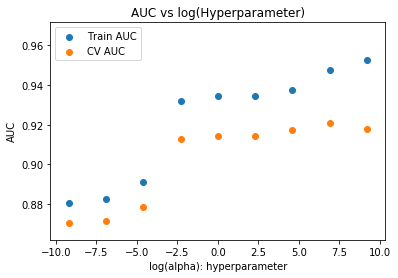

In [80]:
optimal_alpha_auc = ind[cv_auc.index(max(cv_auc))]
print('\nThe optimal alpha is (according to auc curve (max auc)): ' , optimal_alpha_auc)

plt.plot(alpha_list, train_auc, label='Train AUC')
plt.plot(alpha_list, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs Hyperparameter")
plt.show()

plt.plot(np.log(alpha_list), train_auc, label='Train AUC')
plt.plot(np.log(alpha_list), cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("log(alpha): hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs log(Hyperparameter)")
plt.show()


plt.scatter(alpha_list, train_auc, label='Train AUC')
plt.scatter(alpha_list, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs Hyperparameter")
plt.show()

plt.scatter(np.log(alpha_list), train_auc, label='Train AUC')
plt.scatter(np.log(alpha_list), cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("log(alpha): hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs log(Hyperparameter)")
plt.show()



****Test accuracy for alpha = 1000.000000 is 90.257576%


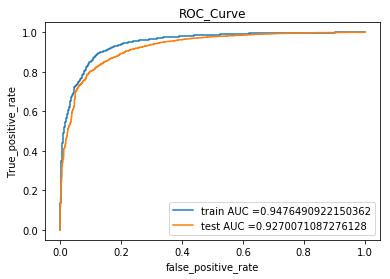

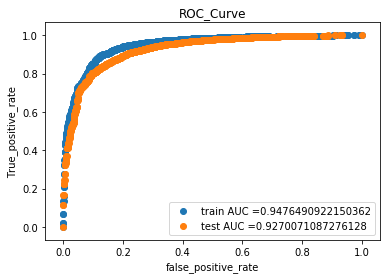

In [81]:
rbf_svm = SVC(C  =optimal_alpha_auc)
cg_cv = CalibratedClassifierCV(base_estimator = rbf_svm)
cg_cv.fit(X_train_vect_tfidf, y_train)
pred = cg_cv.predict(X_test_vect_tfidf)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for alpha = %f is %f%%' % (optimal_alpha_auc,acc))

train_fpr, train_tpr, thresholds = roc_curve(y_train, cg_cv.predict_proba(X_train_vect_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, cg_cv.predict_proba(X_test_vect_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("false_positive_rate")
plt.ylabel("True_positive_rate")
plt.title("ROC_Curve")
plt.show()



plt.scatter(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.scatter(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("false_positive_rate")
plt.ylabel("True_positive_rate")
plt.title("ROC_Curve")
plt.show()

print("="*100)



# Confusion Matrix(Train)

In [82]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix\n")
print(confusion_matrix(y_train, cg_cv.predict(X_train_vect_tfidf)))

Train confusion matrix

[[ 757  586]
 [ 124 7511]]


# Heat map (Train)

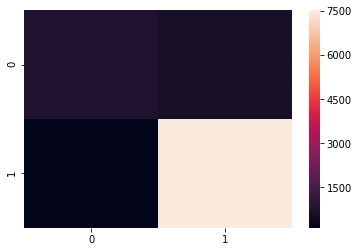

In [83]:
sns.heatmap(confusion_matrix(y_train, cg_cv.predict(X_train_vect_tfidf)))

# Confusion Matrix (Test)

In [84]:
print("Test confusion matrix\n")
print(confusion_matrix(y_test, cg_cv.predict(X_test_vect_tfidf)))

Test confusion matrix

[[ 511  521]
 [ 122 5446]]


# Heat Map (test)

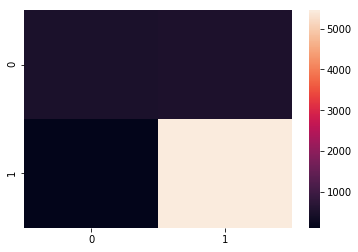

In [85]:
sns.heatmap(confusion_matrix(y_test, cg_cv.predict(X_test_vect_tfidf)))

### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

# GridSearch CV

In [86]:
# Please write all the code with proper documentation

from sklearn.linear_model import SGDClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
tuned_parameters = [{'C': [10**-4,10**-3,10**-2, 10**-1, 10**0, 10**1,10**2,10**3,10**4]}]
alpha_list = [10**-4,10**-3,10**-2, 10**-1, 10**0, 10**1,10**2,10**3,10**4]
#Using GridSearchCV
model = GridSearchCV(SVC(), tuned_parameters, scoring = 'roc_auc')
model.fit(X_train_vectors, y_train)

print(model.best_estimator_)
print(model.score(X_test_vectors, y_test))

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
0.8928758882428941


# SimpleCV

In [87]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
alpha_list = [10**-4,10**-3,10**-2, 10**-1, 10**0, 10**1,10**2,10**3,10**4]
ind = []
train_auc = []
cv_auc = []
for i in tqdm(alpha_list):
    rbf_svm = SVC(C = i)
    cg_cv = CalibratedClassifierCV(base_estimator = rbf_svm)
    cg_cv.fit(X_train_vectors, y_train)
    ind.append(i)
    y_train_pred =  cg_cv.predict_proba(X_train_vectors)[:,1]
    y_cv_pred =  cg_cv.predict_proba(X_cv_vectors)[:,1]
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:34<00:00, 13.90s/it]


# Plots


The optimal alpha is (according to auc curve (max auc)):  1000


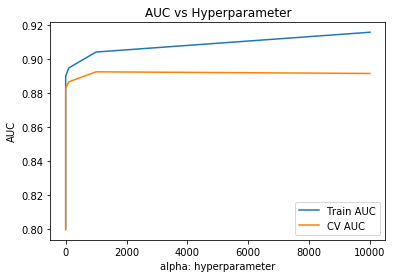

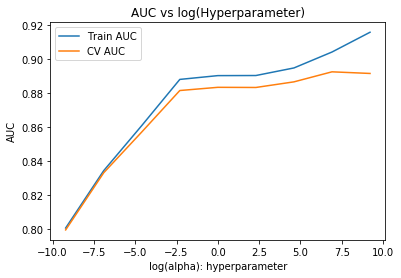

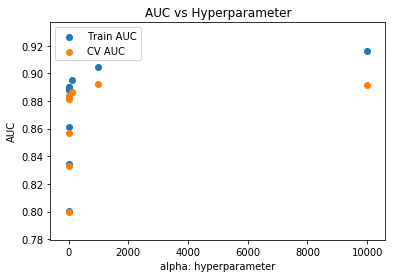

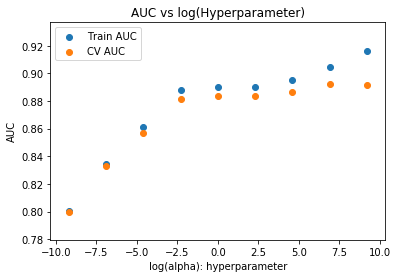

In [88]:
optimal_alpha_auc = ind[cv_auc.index(max(cv_auc))]
print('\nThe optimal alpha is (according to auc curve (max auc)): ' , optimal_alpha_auc)

plt.plot(alpha_list, train_auc, label='Train AUC')
plt.plot(alpha_list, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs Hyperparameter")
plt.show()

plt.plot(np.log(alpha_list), train_auc, label='Train AUC')
plt.plot(np.log(alpha_list), cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("log(alpha): hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs log(Hyperparameter)")
plt.show()


plt.scatter(alpha_list, train_auc, label='Train AUC')
plt.scatter(alpha_list, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs Hyperparameter")
plt.show()

plt.scatter(np.log(alpha_list), train_auc, label='Train AUC')
plt.scatter(np.log(alpha_list), cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("log(alpha): hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs log(Hyperparameter)")
plt.show()



****Test accuracy for alpha = 1000.000000 is 88.560606%


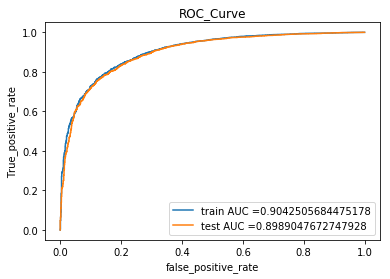

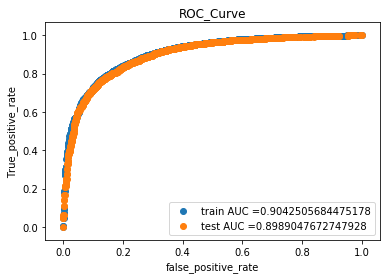

In [89]:
rbf_svm = SVC(C = optimal_alpha_auc)
cg_cv = CalibratedClassifierCV(base_estimator = rbf_svm)
cg_cv.fit(X_train_vectors, y_train)
pred = cg_cv.predict(X_test_vectors)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for alpha = %f is %f%%' % (optimal_alpha_auc,acc))

train_fpr, train_tpr, thresholds = roc_curve(y_train, cg_cv.predict_proba(X_train_vectors)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, cg_cv.predict_proba(X_test_vectors)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("false_positive_rate")
plt.ylabel("True_positive_rate")
plt.title("ROC_Curve")
plt.show()



plt.scatter(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.scatter(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("false_positive_rate")
plt.ylabel("True_positive_rate")
plt.title("ROC_Curve")
plt.show()

print("="*100)


# Confusion Matrix (Train)

In [90]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix\n")
print(confusion_matrix(y_train, cg_cv.predict(X_train_vectors)))

Train confusion matrix

[[ 556  787]
 [ 166 7469]]


# Heat map ( Train)

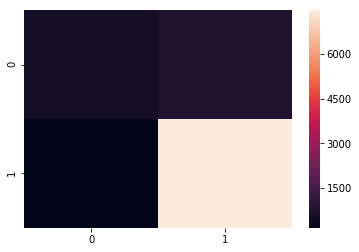

In [91]:
sns.heatmap(confusion_matrix(y_train, cg_cv.predict(X_train_vectors)))

# Confusion matrix ( Test)

In [92]:
print("Test confusion matrix\n")
print(confusion_matrix(y_test, cg_cv.predict(X_test_vectors)))

Test confusion matrix

[[ 412  620]
 [ 135 5433]]


# Heat map (test)

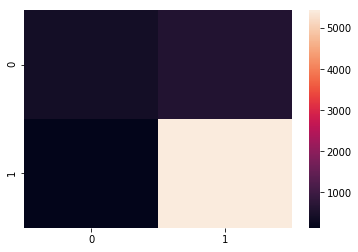

In [93]:
sns.heatmap(confusion_matrix(y_test, cg_cv.predict(X_test_vectors)))

### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

# GridSearch CV

In [94]:
# Please write all the code with proper documentation

from sklearn.linear_model import SGDClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV

tuned_parameters = [{'C': [10**-4,10**-3,10**-2, 10**-1, 10**0, 10**1,10**2,10**3,10**4]}]
alpha_list = [10**-4,10**-3,10**-2, 10**-1, 10**0, 10**1,10**2,10**3,10**4]
#Using GridSearchCV
model = GridSearchCV(SVC(), tuned_parameters, scoring = 'roc_auc')
model.fit(tfidf_X_train_vectors, y_train)

print(model.best_estimator_)
print(model.score(tfidf_X_test_vectors, y_test))

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
0.8663084806312928


# Simple CV

In [95]:
# Please write all the code with proper documentation
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
alpha_list = [10**-4,10**-3,10**-2, 10**-1, 10**0, 10**1,10**2,10**3,10**4]
ind = []
train_auc = []
cv_auc = []
for i in tqdm(alpha_list):
    rbf_svm = SVC(C  =i)
    cg_cv = CalibratedClassifierCV(base_estimator = rbf_svm)
    cg_cv.fit(tfidf_X_train_vectors, y_train)
    ind.append(i)
    y_train_pred =  cg_cv.predict_proba(tfidf_X_train_vectors)[:,1]
    y_cv_pred =  cg_cv.predict_proba(tfidf_X_cv_vectors)[:,1]
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [02:04<00:00, 22.16s/it]


# Plots


The optimal alpha is (according to auc curve (max auc)):  1000


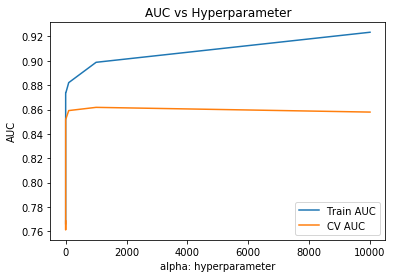

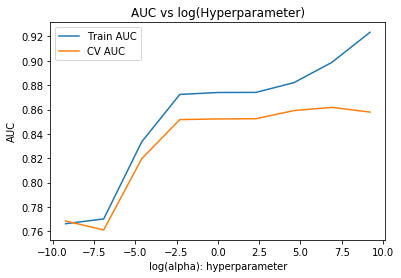

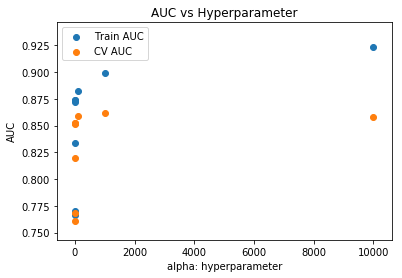

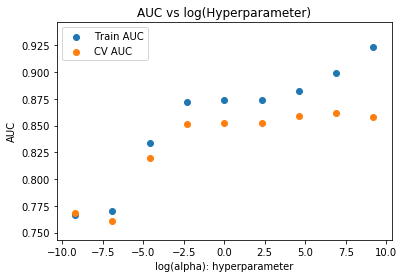

In [96]:
optimal_alpha_auc = ind[cv_auc.index(max(cv_auc))]
print('\nThe optimal alpha is (according to auc curve (max auc)): ' , optimal_alpha_auc)

plt.plot(alpha_list, train_auc, label='Train AUC')
plt.plot(alpha_list, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs Hyperparameter")
plt.show()

plt.plot(np.log(alpha_list), train_auc, label='Train AUC')
plt.plot(np.log(alpha_list), cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("log(alpha): hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs log(Hyperparameter)")
plt.show()


plt.scatter(alpha_list, train_auc, label='Train AUC')
plt.scatter(alpha_list, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs Hyperparameter")
plt.show()

plt.scatter(np.log(alpha_list), train_auc, label='Train AUC')
plt.scatter(np.log(alpha_list), cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("log(alpha): hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs log(Hyperparameter)")
plt.show()



****Test accuracy for alpha = 1000.000000 is 87.636364%


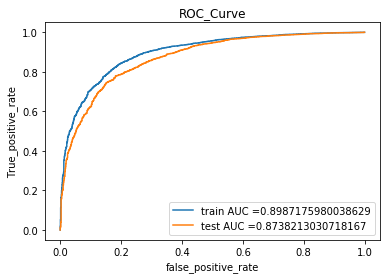

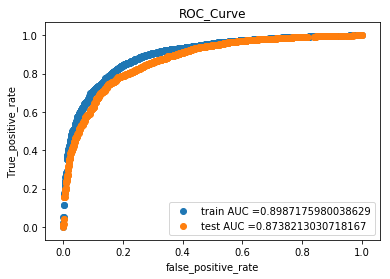

In [97]:
rbf_svm = SVC(C  =optimal_alpha_auc)
cg_cv = CalibratedClassifierCV(base_estimator = rbf_svm)
cg_cv.fit(tfidf_X_train_vectors, y_train)
pred = cg_cv.predict(tfidf_X_test_vectors)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for alpha = %f is %f%%' % (optimal_alpha_auc,acc))

train_fpr, train_tpr, thresholds = roc_curve(y_train, cg_cv.predict_proba(tfidf_X_train_vectors)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, cg_cv.predict_proba(tfidf_X_test_vectors)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("false_positive_rate")
plt.ylabel("True_positive_rate")
plt.title("ROC_Curve")
plt.show()



plt.scatter(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.scatter(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("false_positive_rate")
plt.ylabel("True_positive_rate")
plt.title("ROC_Curve")
plt.show()

print("="*100)


# Confusion Matrix ( Train)

In [98]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix\n")
print(confusion_matrix(y_train, cg_cv.predict(tfidf_X_train_vectors)))

Train confusion matrix

[[ 432  911]
 [ 134 7501]]


# Heat Map (Train)

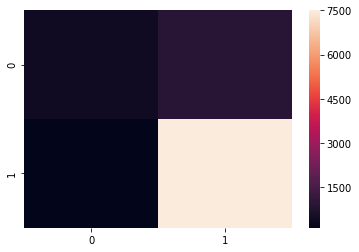

In [99]:
sns.heatmap(confusion_matrix(y_train, cg_cv.predict(tfidf_X_train_vectors)))

# Confusion Matrix (Test)

In [100]:
print("Test confusion matrix\n")
print(confusion_matrix(y_test, cg_cv.predict(tfidf_X_test_vectors)))

Test confusion matrix

[[ 315  717]
 [  99 5469]]


# Heat Map (Test)

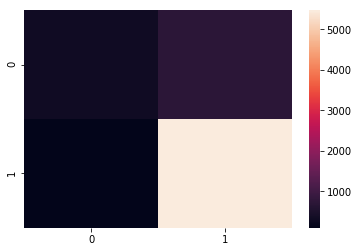

In [101]:
sns.heatmap(confusion_matrix(y_test, cg_cv.predict(tfidf_X_test_vectors)))

# [6] Conclusions

In [118]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "SVM_Type", "Hyperparameter", "AUC"]
x.add_row(["BOW", "Linear", 0.001, 0.9567])
x.add_row(["TFIDF", "Linear", 0.0001, 0.966])
x.add_row(["W2V", "Linear", 0.001, 0.9196])
x.add_row(["TFIDFW2V", "Linear", 0.001, 0.8947])
x.add_row(["BOW", "RBF", 100, 0.92395])
x.add_row(["TFIDF", "RBF", 1000, 0.927])
x.add_row(["W2V", "RBF", 1000, 0.8989])
x.add_row(["TFIDFW2V", "RBF", 1000, 0.8738])
print(x)


+------------+----------+----------------+---------+
| Vectorizer | SVM_Type | Hyperparameter |   AUC   |
+------------+----------+----------------+---------+
|    BOW     |  Linear  |     0.001      |  0.9567 |
|   TFIDF    |  Linear  |     0.0001     |  0.966  |
|    W2V     |  Linear  |     0.001      |  0.9196 |
|  TFIDFW2V  |  Linear  |     0.001      |  0.8947 |
|    BOW     |   RBF    |      100       | 0.92395 |
|   TFIDF    |   RBF    |      1000      |  0.927  |
|    W2V     |   RBF    |      1000      |  0.8989 |
|  TFIDFW2V  |   RBF    |      1000      |  0.8738 |
+------------+----------+----------------+---------+


* The best model of all is TFIDF with Linear SVM .
* Out of all the four models the SVM performs the worst in TFIDF-W2V (RBF)
* Feature Engineering by adding the no. of words in a review as a feature as well as considering the texts from summary tend to increase the performance
* Clearly by seeing the confusion matrix, it can be infered that the data set is imbalanced